## This workbook has been productionized in ./tensor-hero/Shared_Functionality/Preprocessing/Model 1 Preprocessing/m1_preprocessing.py

torch.Size([34, 512, 400])
torch.Size([512, 400])
{0: {'origin': WindowsPath('X:/Training Data/Processed/Angevil Hero II/1. Andy McKee - Ouray'), 'slice': 0}}


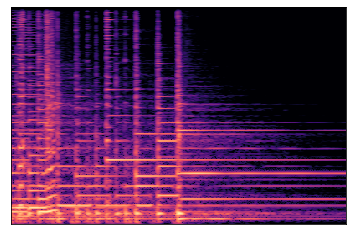

In [6]:
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent.parent / 'Model_1' / 'Preprocessing'))
from m1_preprocessing import *
from librosa.display import specshow
import math

# Get list of processed song paths
unprocessed_path = Path(r'X:\Training Data\Unprocessed')
_, processed_list = get_list_of_ogg_files(unprocessed_path)

# Get paths of notes and corresponding paths of spectrograms
spec_paths = [song / 'spectrogram.npy' for song in processed_list]
notes_paths = [song / 'notes_simplified.npy' for song in processed_list]

def process_spectrogram(spec):
    spec = spec[:, 7:-7]    # Take off the padding
    spec = (spec+80) / 80   # Regularize
    return spec

# Used to create the outfile names of the saved slices
# Will also be able to use these in conjunction with "train_key", "test_key", and "val_key"
# to determine which indices go to which song
train_count = 0
val_count = 0
test_count = 0

# These paths are used to save the data once it is processed
train_path = Path(r'X:\Training Data\Model 1 Training\train')
val_path = Path(r'X:\Training Data\Model 1 Training\val')
test_path = Path(r'X:\Training Data\Model 1 Training\test')

# These dictionaries can act like keys if you'd like to find the origin of a piece of training data
train_key = {}
test_key = {}
val_key = {}

for i in range(len(notes_paths)):
    # Process spectrogram
    spec = np.load(spec_paths[i])
    spec = process_spectrogram(spec)

    # Process notes
    notes = np.load(notes_paths[i])
    notes = notes[7:-7]  # Eliminate padding

    assert notes.shape[0] == spec.shape[1], 'ERROR: Spectrogram and notes shape do not match'
    
    # Get number of 4 second slices
    num_slices = math.floor(spec.shape[1]/400)
    
    # Split notes and spectrogram into bins
    spec_bins = np.array([spec[:,i*400:(i+1)*400] for i in range(num_slices)])
    notes_bins = np.array([notes[i*400:(i+1)*400] for i in range(num_slices)])
    
    # This list will hold the pytorch note representations
    torch_notes = []
    for i in range(num_slices):
        t_notes = notes_to_output_space(notes_bins[i,:])
        t_notes = prepare_notes_tensor(t_notes)
        torch_notes.append(t_notes)
    
    # Convert the spectrogram to pytorch tensor
    torch_spec = torch.tensor(spec_bins, dtype=torch.float)
    print(torch_spec.shape)

    # Generate random integers to determine which folder the data shall be put into
    train_test_split_key = np.random.randint(10, size=num_slices)

    for idx, k in enumerate(train_test_split_key):
        # Define prepend path and count based on value of train_test_split_key
        if k == 9:
            prepend_path = test_path
            count = test_count
        elif k == 8:
            prepend_path = val_path
            count = val_count
        else:
            prepend_path = train_path
            count = train_count
        
        # Save file
        spec_outfile = prepend_path / 'spectrograms' / (str(count) + '.pt')
        notes_outfile = prepend_path / 'notes' / (str(count) + '.pt') 
        torch.save(torch_spec[idx,...], spec_outfile)
        torch.save(torch_notes[idx], notes_outfile)

        # Increment counter, populate key
        if k == 9:
            test_key[test_count] = {'origin' : processed_list[idx], 'slice' : idx}
            test_count += 1
        elif k == 8:
            val_key[test_count] = {'origin' : processed_list[idx], 'slice' : idx}
            val_count += 1
        else:
            train_key[test_count] = {'origin' : processed_list[idx], 'slice' : idx}
            train_count += 1
        break

    print(train_key)

    specshow(spec_bins[33])
    break

## My computer is running out of space so this lil cell is going to help clean it up

You can use it to delete the useless song.npy files out of training data, with a little manipulation

In [21]:
import os
ogg_list, _ = get_list_of_ogg_files(unprocessed_path)

ogg_list[0].parts

song_npy_list = []
for song in ogg_list:
    song_npy_list.append(Path(song.parts[0] + '\\' + song.parts[1] + '\\' + 'Processed' + '\\' + song.parts[3] + '\\' + song.parts[4] + '\\' + 'song.npy'))

for song in song_npy_list:
    try:
        os.remove(song)
    except:
        continue


In [26]:
spec_test = torch.load(r'X:\Training Data\Model 1 Training\train\spectrograms\37.pt')

print(spec_test.shape)

spec_npy = spec_test.numpy()
print(spec_npy.shape)

torch.Size([512, 400])
(512, 400)


In [28]:
np.save('spec_npy.npy', spec_npy)